# Summary
1. There are great differences in the gender and ethnic distributions of applicants to different job bulletins
2. There are differences in the readabilities of job bulletins, even for jobs with similar seniority and subject matter, for example airport managers and airport planners
3. I identified sets of words that predict when a job bulletin will differ in the gender/ethnic distribution of applicants from that of the total applicant pool to all LA jobs: future qualitative research on the use of these words in context will help to find non-biasing substitutions.
4. One reason for bias in an applicant pool is that candidates from under-represented groups do not appreciate the flexibility of some job requirements. I interpreted poor readability as overly complex requirements where flexibility might be available. By comparing jobs with different readabilities but similar levels of seniority and subject matter, bulletin writers at the Personnel Department may be able to trim down the lists of requirements to what is strictly necessary.
5. However, the results from the two analyses do not necessarily reconcile: looking at all jobs, the distribution of to  candidates isn't predicted by readability; there are too few jobs in the data set to perform this analysis stratified by seniority and subject matter. 

In [1]:
library(tm)
library(tidyverse)
library(tidytext)
library(slam)
library(entropy)
library(rvest)
library(quanteda)
set.seed(64953771)

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:httr’:

    content

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.1          ✔ dplyr   0.8.1     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ NLP::content()      masks httr::content()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
Loading required package: xml2

Attaching package: ‘rvest’

The following object is masked from ‘package:purrr’:

    pluck

The following object is masked from ‘package:readr’:

    guess_encoding

Package version: 1.4.3
Parallel computing: 2 of 4 threads used.
See https://quanteda.io for tutorials and examples.

Attaching package: ‘quanteda’

The followi

# Read in Job Applicant Data



In [2]:
application_data <- read_csv("https://data.lacity.org/api/views/mkf9-fagf/rows.csv") %>% 
  janitor::clean_names() %>% 
  mutate(fiscal_year = as.ordered(fiscal_year))

Parsed with column specification:
cols(
  `Fiscal Year` = col_character(),
  `Job Number` = col_character(),
  `Job Description` = col_character(),
  `Apps Received` = col_double(),
  Female = col_double(),
  Male = col_double(),
  Unknown_Gender = col_double(),
  Black = col_double(),
  Hispanic = col_double(),
  Asian = col_double(),
  Caucasian = col_double(),
  `American Indian/ Alaskan Native` = col_double(),
  Filipino = col_double(),
  Unknown_Ethnicity = col_double()
)


# Calculate relative-entropy of individual job applications vs. the total
- Assumption: there are enough jobs in this dataset that the total applicant pool reflects the gender and ethnic distribution of the City of Los Angeles
- Assumption: the more that the distribution of gender or ethnicity among the applicants to _a_ job differs from that of the total applicant pool, the more room for improvement in terms of biased language
- Assumption: Language that carries some bias predicts the difference between the distribution of social groups in an applicant pool for a given job and that of the total pool
- Measure: the relative-entropies of the social-group-distribution for the pool applying to each job vs. that of the total 
    + The measure is related to the $\chi^2$ statistic comparing the two distributions as well as their KL divergence

In [3]:
apps_gen_dist <- application_data %>%
  select(female, male, unknown_gender) %>%
  colSums

application_data %>%
  select(female, male, unknown_gender, apps_received) %>% 
  mutate(female = female/apps_received,
    male = male/apps_received, 
    unknown_gender = unknown_gender/apps_received) %>% 
  apply(., 2, median) %>% 
  signif(2)

application_data %>%
  select( black,
    hispanic,
    asian,
    caucasian,
    american_indian_alaskan_native,
    filipino,
    unknown_ethnicity, apps_received) %>% 
  mutate( black = black / apps_received,
    hispanic = hispanic / apps_received,
    asian = asian / apps_received,
    caucasian = caucasian / apps_received,
    american_indian_alaskan_native =  american_indian_alaskan_native / apps_received,
    filipino = filipino / apps_received,
    unknown_ethnicity = unknown_ethnicity / apps_received) %>% 
  apply(., 2, median) %>% 
  signif(2)


# Due to low frequency of unknown gender, I'm removing that category from analysis
# Due to low frequencies of American Indian/Alaskan Native, and Filipino ethnicities, I am lumping them as 'Other Ethnicity' with the people reporting 
# unknown ethnicity; this is likely to cause some aggregation bias

application_data <- application_data %>% 
  mutate(other_ethnicity = american_indian_alaskan_native + filipino + unknown_ethnicity ) %>% 
  select(-unknown_gender, -american_indian_alaskan_native, -filipino,
    -unknown_ethnicity)


apps_gender_dist <- sweep(
  x = as.array(apps_gen_dist),
  MARGIN = 1,
  STATS = sum(apps_gen_dist),
  FUN = "/"
) %>% t





apps_eth_dist <-  application_data %>%
  select(
    black,
    hispanic,
    asian,
    caucasian,
    other_ethnicity
  ) %>%
  colSums
apps_ethnic_dist <- sweep(
  x = as.array(apps_eth_dist),
  MARGIN = 1,
  STATS = sum(apps_eth_dist),
  FUN = "/"
) %>% t

job_gen_dist <- application_data %>%
  group_by(job_description) %>%
  mutate(
    total = female + male,
    female = female / total,
    male = male / total
  )

job_eth_dist <- application_data %>%
  group_by(job_description) %>%
  mutate(
    total = black + hispanic + asian + caucasian + other_ethnicity,
    black = black / total,
    hispanic = hispanic / total,
    asian = asian / total,
    caucasian = caucasian / total,
    other_ethnicity =  other_ethnicity / total
  )

job_gender_KL <- job_gen_dist %>%
  group_by(job_description) %>%
  do(.data = .,
    data.frame(gen_rel_entropy = KL.plugin(
      freqs1 = as.vector(apps_gender_dist),
      freqs2 = c(.$female, .$male, .$unknown_gender)
    ))) %>% 
  ungroup

job_ethnic_KL <- job_gen_dist %>%
  group_by(job_description) %>%
  do(.data = .,
    data.frame(eth_rel_entropy = KL.plugin(
      freqs1 = as.vector(apps_ethnic_dist),
      freqs2 = with(
        .,
        c(
          black,
          hispanic,
          asian,
          caucasian,
          other_ethnicity
        )
      )
    ))) %>% 
  ungroup

application_missing_groups <- 
  application_data %>% 
  group_by(job_description) %>%
  do(
    .data = . ,
    data.frame(missing_groups = 
        paste(colnames(.)[as.vector(.) == 0], collapse = ", "))) %>%
  ungroup()

application_entropy_data <- left_join(application_data,
  job_gender_KL) %>%
  left_join(job_ethnic_KL) %>%
  left_join(application_missing_groups) %>% 
  mutate(
    class_code = str_extract(pattern = "(\\b)?[[:digit:]]{4}\\b", string = job_description),
  gen_rel_entropy = if_else(is.infinite(gen_rel_entropy),4*max(gen_rel_entropy[is.finite(gen_rel_entropy)],na.rm = TRUE), gen_rel_entropy),
      eth_rel_entropy = if_else(is.infinite(eth_rel_entropy),4*max(eth_rel_entropy[is.finite(eth_rel_entropy)],na.rm = TRUE), eth_rel_entropy)  
  )
  

female           male unknown_gender  apps_received 
         0.190          0.780          0.018        100.000

black                       hispanic 
                       1.5e-01                        2.9e-01 
                         asian                      caucasian 
                       7.5e-02                        2.4e-01 
american_indian_alaskan_native                       filipino 
                       2.8e-03                        3.5e-02 
             unknown_ethnicity                  apps_received 
                       5.8e-02                        1.0e+02

Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown or uninitialised column: 'unknown_gender'.”Warning message in freqs1/freqs2:
“longer object length is not a multiple of shorter object

# Read and clean Job Bulletin Corpus


In [4]:
job_bulletins <- Corpus(
    DirSource(
      directory = "../input/cityofla/CityofLA/Job Bulletins/"
    )
  ) %>% corpus

bulletin_DTM <- dfm(job_bulletins, 
  stem = TRUE,
  tolower = TRUE,
  remove = stopwords()
  ) 



## Weight by tf-idf for latent semantic analysis
bulletin_TF_IDF <- bulletin_DTM %>% 
  dfm_tfidf()

bulletin_TF_IDF <- dfm_trim(bulletin_TF_IDF, min_termfreq = 0.025, termfreq_type = "quantile", force =  TRUE) 
bulletin_TF_IDF <- dfm_subset(bulletin_TF_IDF, subset = (row_sums(bulletin_DTM) > 0))


Warning message in dfm_trim.dfm(bulletin_TF_IDF, min_termfreq = 0.025, termfreq_type = "quantile", :
“dfm has been previously weighted”

# Readability of Job Bulletins
- Assumption 1: the more sentences in a job bulletin and the lower its readability, the more complex its required qualifications.
- Assumption 2: Some proportion of jobs have some proportion of required qualifications that are open to applicant advocacy/relationships/framing, but this can't be stated in the bulletin, and these not-really-required qualifications push people (disproportionately women and people from other underrepresented groups) away from applying. (citation: https://hbr.org/2014/08/why-women-dont-apply-for-jobs-unless-theyre-100-qualified)
- Hypothesis: within a job area (ex: wastewater treatment, Port of LA jobs, accounting, etc.) _and_ seniority level, the highest opportunity for editing to be more inclusive lies with the bulletins having worst readabilities and most sentences.
- Unreadability: Measure: $log\left(n_{sentence}\right) + \left(-1\right)\cdot\text{Dickes-Steiwer Readability Index}$, sign reversed to reflect _low_ readability
    + The Dickes-Steiwer Index is based on average sentence length, word length, and type-token ratio.
    + Number of sentences is not likely normally-distributed, so average sentence length is probably correlated with number of sentences. I log-transform the number of sentences to reduce this correlation and decrease the chance of artificially increasing the variance of the measure.
- To the degree the hypothesis is supported, I think a practical first step in this editing is to classify each requirement as absolutely required vs. open to any or all of a candidate's advocacy/relationships/varied expertise.


In [5]:
bulletin_readability <- textstat_readability(job_bulletins, measure = "Dickes.Steiwer", intermediate = TRUE) %>% 
  mutate(unreadability_measure = log(St) + (-1)*(Dickes.Steiwer),
        class_code = str_extract(pattern = "(\\b)?[[:digit:]]{4}\\b", string = document)) %>%
  arrange(desc(unreadability_measure))

bulletin_readability %>% 
  select(document, W, St, Dickes.Steiwer,  unreadability_measure) %>% 
  rename(n_words = W, n_sentences = St ) %>% 
  head()


document,n_words,n_sentences,Dickes.Steiwer,unreadability_measure
<chr>,<int>,<int>,<dbl>,<dbl>
Vocational Worker DEPARTMENT OF PUBLIC WORKS.txt,915,27,-610.7016,613.9974
SENIOR ENVIRONMENTAL COMPLIANCE INSPECTOR 4293 042916 REV 051916.txt,1731,56,-597.3664,601.3918
SUPERINTENDENT OF RECREATION AND PARKS OPERATIONS 2472 012618.txt,1406,47,-578.6089,582.4590
VIDEO PRODUCTION COORDINATOR 1802 012717.txt,1683,57,-567.3888,571.4318
INSTRUMENT MECHANIC SUPERVISOR 3844 051917 final.txt,1707,61,-550.2715,554.3823
SENIOR RECREATION DIRECTOR 2446 050517 REV 051117.txt,1325,47,-549.8965,553.7467


One clear outlier in the unreadability measure is that the Vocational Worker job is the least-readable. This is because it has very long sentences, which I attribute to its non-standard format. That is unfortunate, because this job is supposed to be open to basically anyone in order to help them get into the job market. In support of the hypothesis, the other least-readable bulletins are for more senior positions.

# Grouping Job Descriptions by Subject Matter and Seniority
- Even in a perfectly fair world (see: https://en.wikipedia.org/wiki/Justice_as_Fairness#Second_principle:_the_equality_principle), jobs necessarily differ in their requirements
- So, a model that makes comparisons between very different jobs may obscure wording that actually reduces effective equality of opportunity under the noise of words that simply distinguish jobs
- To account for this, I grouped jobs by the subject of the work (e.g. working for the Port of LA vs. Accounting vs. Media Production vs. Construction) and seniority, indicated by the valence words in the job title such as "senior", "supervisor", "aide", etc, where the term "supervisor" adds 1 to the seniority score of a bulletin, while "associate" subtracts 1
- I arbitrarily clustered jobs to 14 subject matter areas so that there would be an average of 50 jobs per cluster.
- I used Ward's method of hierarchical clustering (which was developed in a human resources context) on the Euclidean distances between documents' words


In [6]:
job_title_corpus <- docnames(job_bulletins) %>%
  corpus()
# Seniority Score: Words like senior, supervisor, superintendent, manager, aide

seniority_dictionary <- quanteda::dictionary(
  list (
    junior = c("aide", "associate", "junior", "trainee", "assistant" ),
    senior = c("senior", "supervisor", "manager", "chief", "superintendent", "supervising", "head", "captain", "lieutenant")
  )
)

seniority_dfm <- job_title_corpus %>% 
  dfm(stem = TRUE, dictionary = seniority_dictionary) 
seniority_score <- seniority_dfm %>% 
  convert(to = "data.frame") %>% 
  mutate(seniority = senior - junior)

bulletin_seniorities <- data.frame(document = docnames(job_bulletins),
  seniority = seniority_score$seniority) %>% 
  mutate_if(is.factor, as.character)

# Text distances: 
bulletin_distances <- bulletin_DTM %>% 
  textstat_dist()

bulletin_clusters <- hclust(bulletin_distances, method = "ward.D2") %>%
  cutree(k = 14) 

bulletin_subjects <- data.frame(document = docnames(job_bulletins),
  subject = bulletin_clusters
  ) %>% 
  mutate_if(is.factor, as.character)


readability_seniority_subject_ranked <- inner_join(
  bulletin_readability,
  bulletin_seniorities
) %>% 
  inner_join(bulletin_subjects) %>%
  arrange(desc(seniority), subject, desc(unreadability_measure)) %>% 
  select(document, seniority, subject, unreadability_measure)

head(readability_seniority_subject_ranked, 25)

write_csv(x = readability_seniority_subject_ranked, path = "./bulletins_ranked_by_readability_subject_and_seniority.csv")

Joining, by = "document"
Joining, by = "document"


document,seniority,subject,unreadability_measure
<chr>,<dbl>,<int>,<dbl>
SENIOR COMMUNICATIONS ELECTRICIAN SUPERVISOR 3691 041318.txt,2,3,437.0064
SENIOR PARK MAINTENANCE SUPERVISOR 3146 101416.txt,2,3,432.8390
SENIOR MACHINIST SUPERVISOR 3768 051016.txt,2,8,491.5879
SENIOR UNDERGROUND DISTRIBUTION CONSTRUCTION SUPERVISOR 3815 072817.txt,2,9,477.5579
SENIOR ELECTRICAL REPAIR SUPERVISOR 3856 060118.txt,2,9,439.8361
CHIEF CUSTODIAN SUPERVISOR 3182 041015.txt,2,10,456.7560
SENIOR SURVEY SUPERVISOR 7288 081718.txt,2,10,427.3888
SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,2,10,413.8814
HEAD CUSTODIAN SUPERVISOR 3178 050418.txt,2,10,405.4627


## Least-readable Bulletins by Seniority and Subject Matter
- The table given in `bulletins_ranked_by_readability_subject_and_seniority.csv` and previewed above gives a list of bulletins to target for trimming requirements to what's necessary and/or indicating clearly where applicants can be more flexible
- This trimming could be aided by comparing the requirements of "head" vs. "chief" Custodian Supervisors to see if the difference in requirements between the more accessible "head" position and the "chief" position is due to non-negotiable qualifications; the same goes for comparing the Chief of Airport Planning role to the Airport Manager role

# Topic Model of Job Bulletin Corpus
- I fit a Latent Semantic Analysis (LSA) model with 30 components to the tf-idf-weighted job bulletins
- The idea is that some combinations of words in a document may predict an unnecessarily-restricted applicant pool.
- LSA is a dimension-reduction technique that operates on word co-occurrences; it should pick out groups of words that appear together in job bulletins
- If the hypothesis that there is biasing language in some bulletins is supported, then that language is detectable as: 
    + LSA dimensions that predict job bulletins that have different social group distributions from the total applicant pool
    + Words with high loadings on those LSA dimensions in the direction of bias (positive loadings in dimensions that are positively associated with bias; negative loadings in dimensions that are negatively associated with bias)


In [7]:
# dependency on Gnu Scientific Library is probably why I can't get topicmodels installed
# Refactoring to use Latent Semantic Analysis (or maybe Correspondence analysis)
topics_lsa  <- bulletin_DTM %>% 
            as.dfm() %>%
            textmodel_lsa(nd = 30)
topics <- topics_lsa$docs %>% 
  data.frame %>% 
  rownames_to_column() %>% 
  mutate(class_code = str_extract(pattern = "\\b[[:digit:]]{4}\\b", string= rowname))


# Readability and Relative Entropy of Candidate Social Groups
- I tested the readability hypothesis by regressing relative entropy of the candidates of a job on the job bulletin's unreadability score using OLS regression
- I expected this coefficient to be positive: less readable -> reduced applicant pool
- There's little evidence of association; this is because some jobs lacked any female applicants or did not have any applicants from one of the ethnic groups.
    - Further, the very-restricted applicant pools are distributed over the same range of readabilities as the unrestricted pools, as shown in the scatterplot below; the red line is an isotonic regression


Joining, by = "class_code"


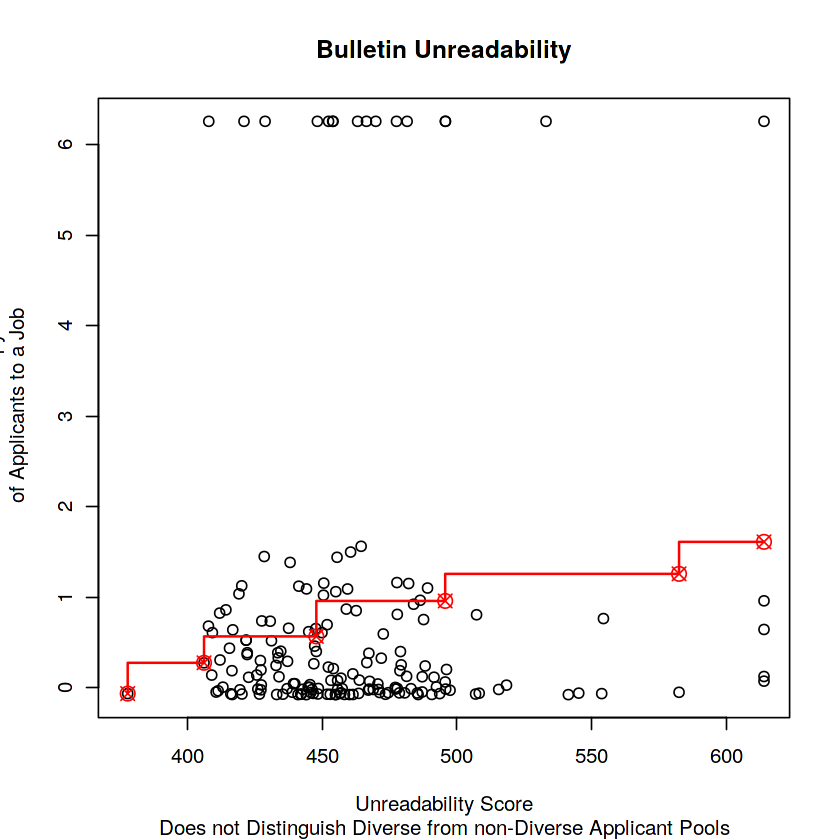

In [8]:
unreadability_by_entropy  <- inner_join(bulletin_readability, application_entropy_data)
unread_entropy_gender_lm  <- lm(gen_rel_entropy ~ unreadability_measure, data = unreadability_by_entropy)
unread_entropy_ethnicity_lm  <- lm(eth_rel_entropy ~ unreadability_measure, data = unreadability_by_entropy)
isoreg(x = unreadability_by_entropy$unreadability_measure, y = unreadability_by_entropy$gen_rel_entropy) %>% plot(xlab = "Unreadability Score", ylab = "Relative Entropy\n of Applicants to a Job", main = "Bulletin Unreadability",  sub = "Does not Distinguish Diverse from non-Diverse Applicant Pools")


# Latent Semantic Features and Entropy of Candidate Social Groups


In [9]:
topics_and_entropy <- inner_join(topics, application_entropy_data)

gendered_topic_lm <- lm(gen_rel_entropy ~ .,
  data = topics_and_entropy %>% 
    select(gen_rel_entropy, setdiff(colnames(topics), c("rowname", "class_code"))))
ethnic_topic_lm <- lm(eth_rel_entropy ~ .,
  data = topics_and_entropy %>% 
    select(eth_rel_entropy, setdiff(colnames(topics), c("rowname", "class_code"))))

 summary(gendered_topic_lm)

 summary(ethnic_topic_lm)



Joining, by = "class_code"



Call:
lm(formula = gen_rel_entropy ~ ., data = topics_and_entropy %>% 
    select(gen_rel_entropy, setdiff(colnames(topics), c("rowname", 
        "class_code"))))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5926 -0.9980 -0.4357  0.2592  5.5609 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1.0689     1.2079   0.885   0.3774  
X1            3.2588    30.9730   0.105   0.9163  
X2            0.1863     6.7148   0.028   0.9779  
X3           -6.4359     3.8981  -1.651   0.1005  
X4           -1.9675     4.3416  -0.453   0.6510  
X5           -0.8782     4.8171  -0.182   0.8555  
X6          -12.0488     4.8672  -2.475   0.0142 *
X7           -0.5688     6.1853  -0.092   0.9268  
X8            2.1255     4.2026   0.506   0.6136  
X9            9.5015     4.6370   2.049   0.0419 *
X10           2.4142     4.6281   0.522   0.6025  
X11          -6.2078     4.9694  -1.249   0.2132  
X12          -0.5685     3.4887  -0.163   0.8707  
X13         


Call:
lm(formula = eth_rel_entropy ~ ., data = topics_and_entropy %>% 
    select(eth_rel_entropy, setdiff(colnames(topics), c("rowname", 
        "class_code"))))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2129 -0.8716 -0.4857  0.2091  3.9815 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  2.24428    1.03663   2.165   0.0317 *
X1          29.88845   26.58086   1.124   0.2623  
X2           7.46120    5.76261   1.295   0.1970  
X3          -4.05986    3.34535  -1.214   0.2265  
X4           6.35613    3.72594   1.706   0.0897 .
X5          -5.89136    4.13399  -1.425   0.1558  
X6          -4.82756    4.17702  -1.156   0.2493  
X7           1.89133    5.30816   0.356   0.7220  
X8           0.00789    3.60661   0.002   0.9983  
X9           2.40967    3.97945   0.606   0.5456  
X10         -1.48893    3.97179  -0.375   0.7082  
X11          2.91212    4.26470   0.683   0.4956  
X12          0.78079    2.99397   0.261   0.7946  
X13         

# Possibly Bias-Associated Word-sets
- These are words that, when co-occurring in a job bulletin, significantly predict that a job bulletin's applicant pool differed in ethnic or ethnic distribution from that of the overall pool
- My recommendation is to look at these words in context, then interview members of under-represented groups to identify biasing connotations 


In [10]:
gender_bias_words_i <- topics_lsa$features[,9] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
gender_bias_words_i <- gender_bias_words_i[str_length(gender_bias_words_i) > 0]

gender_bias_words_ii <- topics_lsa$features[,17] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
gender_bias_words_ii <- gender_bias_words_ii[str_length(gender_bias_words_ii) > 0]

gender_bias_words_iii <- topics_lsa$features[,6] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
gender_bias_words_iii <- gender_bias_words_iii[str_length(gender_bias_words_iii) > 0]


ethnic_bias_words_i <- topics_lsa$features[,3] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
ethnic_bias_words_i <- ethnic_bias_words_i[str_length(ethnic_bias_words_i) > 0]

ethnic_bias_words_ii <- topics_lsa$features[,13] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
ethnic_bias_words_ii <- ethnic_bias_words_ii[str_length(ethnic_bias_words_ii) > 0]

ethnic_bias_words_iii <- topics_lsa$features[,18] %>% abs %>% sort() %>% `[`(1:20) %>% names() %>% str_extract_all(pattern = "[:alpha:]*") %>% unlist
ethnic_bias_words_iii <- ethnic_bias_words_iii[str_length(ethnic_bias_words_iii) > 0]



print("Words associated with Gender Distribution: ")
bind_rows(data.frame(set = "Set 1", words = gender_bias_words_i), 
          data.frame(set=  "Set 2", words = gender_bias_words_ii), #
          data.frame(set = "Set 3", words = gender_bias_words_iii)) %>%
knitr::kable()

print("Words associated with Ethnic Distribution: ")
bind_rows(data.frame(set = "Set 1", words = ethnic_bias_words_i), 
          data.frame(set=  "Set 2", words = ethnic_bias_words_ii), #
          data.frame(set = "Set 3", words = ethnic_bias_words_iii)) %>%
knitr::kable()

[1] "Words associated with Gender Distribution: "


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”



|set   |words       |
|:-----|:-----------|
|Set 1 |straighten  |
|Set 1 |hundr       |
|Set 1 |outag       |
|Set 1 |unfir       |
|Set 1 |data        |
|Set 1 |driven      |
|Set 1 |shaven      |
|Set 1 |cite        |
|Set 1 |twenti      |
|Set 1 |sub         |
|Set 1 |panel       |
|Set 1 |substructur |
|Set 2 |contractu   |
|Set 2 |teletyp     |
|Set 2 |coupl       |
|Set 2 |davis       |
|Set 2 |bacon       |
|Set 2 |profit      |
|Set 2 |competitv   |
|Set 3 |mercuri     |
|Set 3 |landlord    |
|Set 3 |ten         |
|Set 3 |choos       |
|Set 3 |proactiv    |
|Set 3 |lay         |
|Set 3 |out         |
|Set 3 |voucher     |
|Set 3 |lbs         |

[1] "Words associated with Ethnic Distribution: "


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”



|set   |words      |
|:-----|:----------|
|Set 1 |adapt      |
|Set 1 |player     |
|Set 1 |refund     |
|Set 1 |pick       |
|Set 1 |up         |
|Set 1 |infer      |
|Set 1 |spss       |
|Set 1 |system     |
|Set 1 |wid        |
|Set 2 |job        |
|Set 2 |sit        |
|Set 2 |work       |
|Set 2 |rel        |
|Set 2 |hydron     |
|Set 2 |airflow    |
|Set 2 |reclaim    |
|Set 2 |marina     |
|Set 2 |twic       |
|Set 2 |ditch      |
|Set 2 |sledgehamm |
|Set 2 |steel      |
|Set 2 |to         |
|Set 2 |just       |
|Set 3 |fourth     |
|Set 3 |densiti    |
|Set 3 |tdd        |
|Set 3 |hundr      |
|Set 3 |in         |
|Set 3 |depth      |
|Set 3 |traffic    |
|Set 3 |rel        |
|Set 3 |volt       |
|Set 3 |ohm        |
|Set 3 |clamp      |
|Set 3 |on         |

# Ethnicity-distribution-associated Word Sets
- Technical words that distinguish knowledge work from physical work appear: "SPSS", "ditch", "steel", "sledgehammer", "clamp"
- Other words may have cultural associations that may have different connotations in different groups: "infer", "marina", "adapt"

# Comparison to Published Gendered Wordlists
- Gendered language in job bulletins has been highlighted by several people, including in the Open Source Gender Decoder app by Kat Matfield (http://gender-decoder.katmatfield.com/)
- I've borrowed the wordlists she used in this app  to use as a gold-standard of bias detection for comparison with the unreadability and LSA approaches 
- The tables above identified 'driven', 'competitive' as words that predict different gender distributions of applicants; these words are also used by the app. 'pro-active' also appeared above, while Matfield lists "active." 
- Unfortunately, these wordlists are not very predictive of gender/ethnic distribution in this context, which may be because the specific vocabulary used for government job postings differs from that used in the research used to develop the app



In [11]:
gendered_wordlists <- read_html("https://github.com/lovedaybrooke/gender-decoder/blob/master/app/wordlists.py") %>% 
  html_nodes("table") %>% 
  html_nodes("td") %>% 
  html_text() 

gendered_words <- gendered_wordlists[grepl(gendered_wordlists, pattern = "^[[:space:]]*\\\"")] %>% 
  str_squish() 
## Regress gendered wordlist_dtms on relative_entropy
gendered_words <- gendered_words[1:109] %>%
  str_remove_all("[\\\" ,]")
gendered_dictionary <- dictionary(list(
  feminine = gendered_words[1:50],
  masculine = gendered_words[51:102] 
))

gendered_DTM <- dfm(job_bulletins,
  stem = TRUE,
    remove = stopwords(),
    
    dictionary = gendered_dictionary) %>% 
  tidytext::tidy() %>% 
  mutate(class_code = str_extract(pattern = "\\b[[:digit:]]{4}\\b", string = document)) %>% 
  right_join(application_entropy_data) %>% 
  spread(key = term, value = count) %>% 
  select(-document, -fiscal_year, -job_number, -job_description,
    -apps_received, -female, -male,
    -black,
          -hispanic,
          -asian,
          -caucasian,
          -other_ethnicity,
          - missing_groups,
       -'<NA>') %>% 
  mutate_if(is.numeric, replace_na, 0)

gendered_genderword_lm <- lm(gen_rel_entropy ~ .,
  data = gendered_DTM %>% select(-eth_rel_entropy, -class_code))
ethnic_genderword_lm <- lm(eth_rel_entropy ~ .,
  data = gendered_DTM %>% select(-gen_rel_entropy,-class_code))



summary(gendered_genderword_lm)
summary(ethnic_genderword_lm)


Joining, by = "class_code"



Call:
lm(formula = gen_rel_entropy ~ ., data = gendered_DTM %>% select(-eth_rel_entropy, 
    -class_code))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8201 -0.8956 -0.6849 -0.0933  5.5361 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.71925    0.18686   3.849 0.000155 ***
feminin      0.04093    0.14877   0.275 0.783495    
masculin     0.21072    0.14094   1.495 0.136304    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.853 on 220 degrees of freedom
Multiple R-squared:  0.01116,	Adjusted R-squared:  0.002168 
F-statistic: 1.241 on 2 and 220 DF,  p-value: 0.2911



Call:
lm(formula = eth_rel_entropy ~ ., data = gendered_DTM %>% select(-gen_rel_entropy, 
    -class_code))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9484 -0.8283 -0.6794 -0.4502  3.6032 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.926855   0.160682   5.768  2.7e-08 ***
feminin     0.009142   0.127935   0.071    0.943    
masculin    0.015918   0.121194   0.131    0.896    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 220 degrees of freedom
Multiple R-squared:  0.0001164,	Adjusted R-squared:  -0.008973 
F-statistic: 0.01281 on 2 and 220 DF,  p-value: 0.9873


# Conclusion and Next Steps
- Conclusions:
  + This is a topic of practical, ethical, and legal importance to the future of the City of Los Angeles; it is important to consult with stakeholders at all levels before implementing these recommendations
  + Data analysis divorced from context is not an approach that can help much in solving this problem 
  + Given the high unreadability of very similar job descriptions and the tendency of candidates from underrepresented groups to overestimate the strictness of job requirements, my recommendation is to pare down requirements to those that are strictly necessary to _start_ a job
  + Some of the gender-associated words match those seen in other work
  + Some ethnicity-associated words may reflect cultural exposures or job types
  + Qualitative research will help find cultural factors and identify unintended connotations
- Next Steps:
  + Nonlinear prediction of applicant pool entropy
  + More sophisticated topic models
  + Stakeholder critique